In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

## Gerando o sinal e amostrando-o

In [45]:
f = 4 
fs = 1000 
fs_n = 10 * f

t = np.arange(0, 2, 1/fs)  
n = np.arange(0, 2, 1/fs_n) 

sinal_t = (np.sin(2 * np.pi * f * t) + 
                  5 * np.sin(2 * np.pi * 0.4 * f * t) + 
                  2 * np.sin(2 * np.pi * 0.1 * f * t))

sinal_n = (np.sin(2 * np.pi * f * n) + 
                   5 * np.sin(2 * np.pi * 0.4 * f * n) + 
                   2 * np.sin(2 * np.pi * 0.1 * f * n))


## Fazendo a interpolação do sinal amostrado:

In [61]:
L = 4

sinal_upsampled = np.zeros(len(sinal_n) * (L + 1)) 
sinal_upsampled[::(L + 1)] = sinal_n

n_upsampled = np.arange(0, 2, 1/(fs_n * (L + 1)))

## Passando os sinais por um filtro FIR :

In [49]:
cutoff_f = f * 2
taps = 100
nyquist_rate_t = fs / 2
nyquist_rate_n = fs_n / 2

filtro_fir_t = signal.firwin(taps, cutoff_f / nyquist_rate_t)

sinal_filtrado_t = signal.lfilter(filtro_fir_t, 1.0, sinal_t)

filtro_fir_n = signal.firwin(taps, cutoff_f / nyquist_rate_n)

sinal_filtrado_n = signal.lfilter(filtro_fir_n, 1.0, sinal_n)

filtro_fir_upsampled = signal.firwin(taps, cutoff_f/ (fs_n * (L + 1) / 2))

sinal_filtrado_upsampled = signal.lfilter(filtro_fir_upsampled, 1.0, sinal_upsampled)

## Sinal Contínuo antes e depois do filtro FIR:

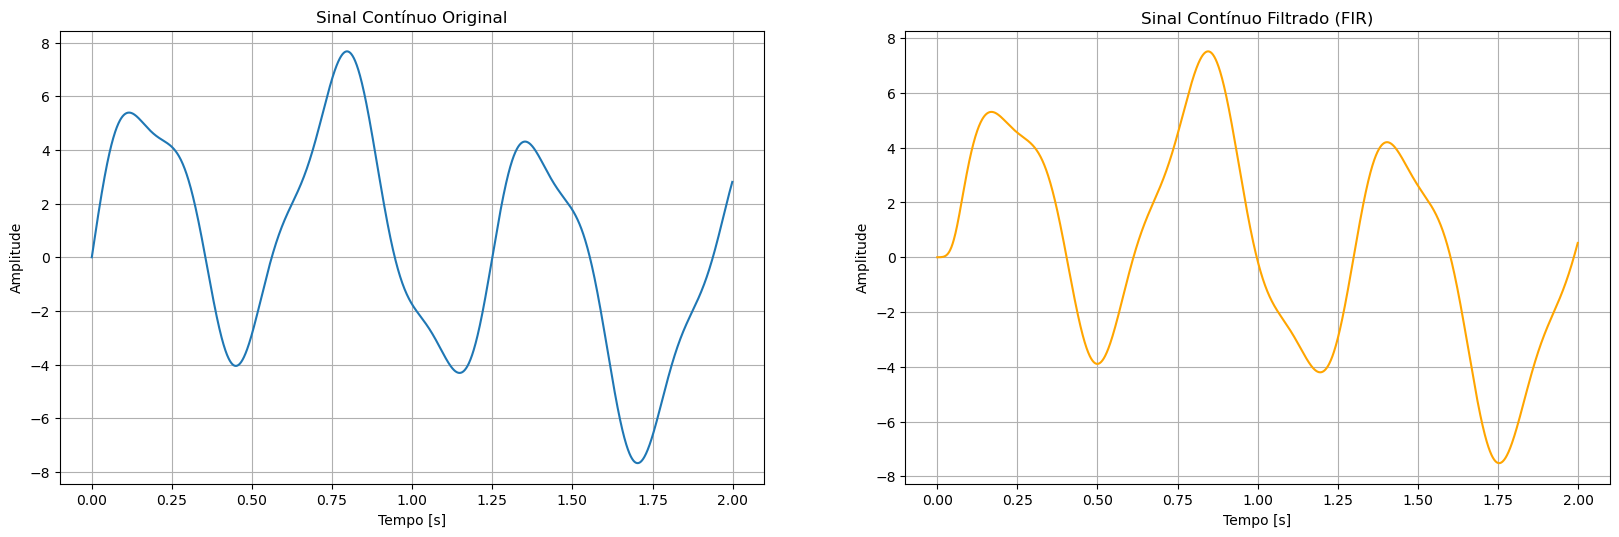

In [53]:
plt.figure(figsize=(20, 20))

plt.subplot(3, 2, 1)
plt.plot(t, sinal_t, label='Original')
plt.title('Sinal Contínuo Original')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(3, 2, 2)
plt.plot(t, sinal_filtrado_t, label='Filtrado', color='orange')
plt.title('Sinal Contínuo Filtrado (FIR)')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')
plt.grid(True)

## Sinal Amostrado antes e depois do Filtro FIR:

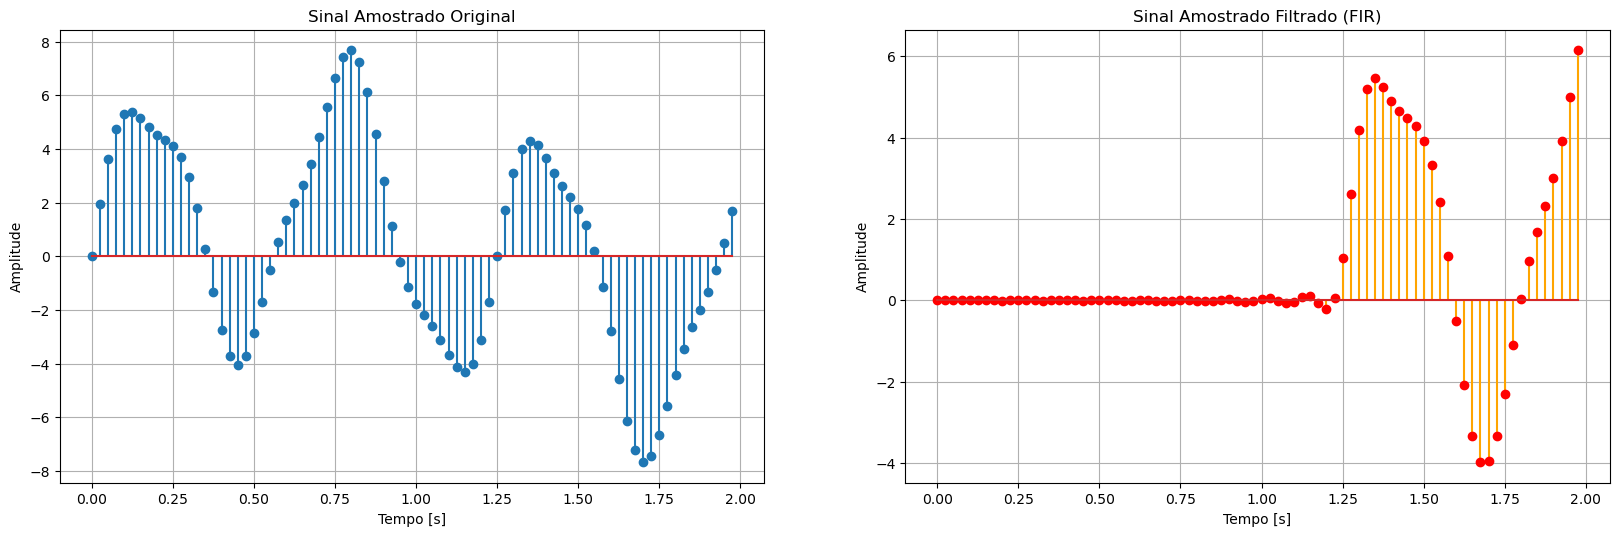

In [57]:
plt.figure(figsize=(20, 20))

plt.subplot(3, 2, 3)
plt.stem(n, sinal_n, label='Original')
plt.title('Sinal Amostrado Original')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(3, 2, 4)
plt.stem(n, sinal_filtrado_n, label='Filtrado', linefmt='orange', markerfmt='ro')
plt.title('Sinal Amostrado Filtrado (FIR)')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude') 
plt.grid(True)

## Sinal Interpolado antes e depois do Filtro FIR:

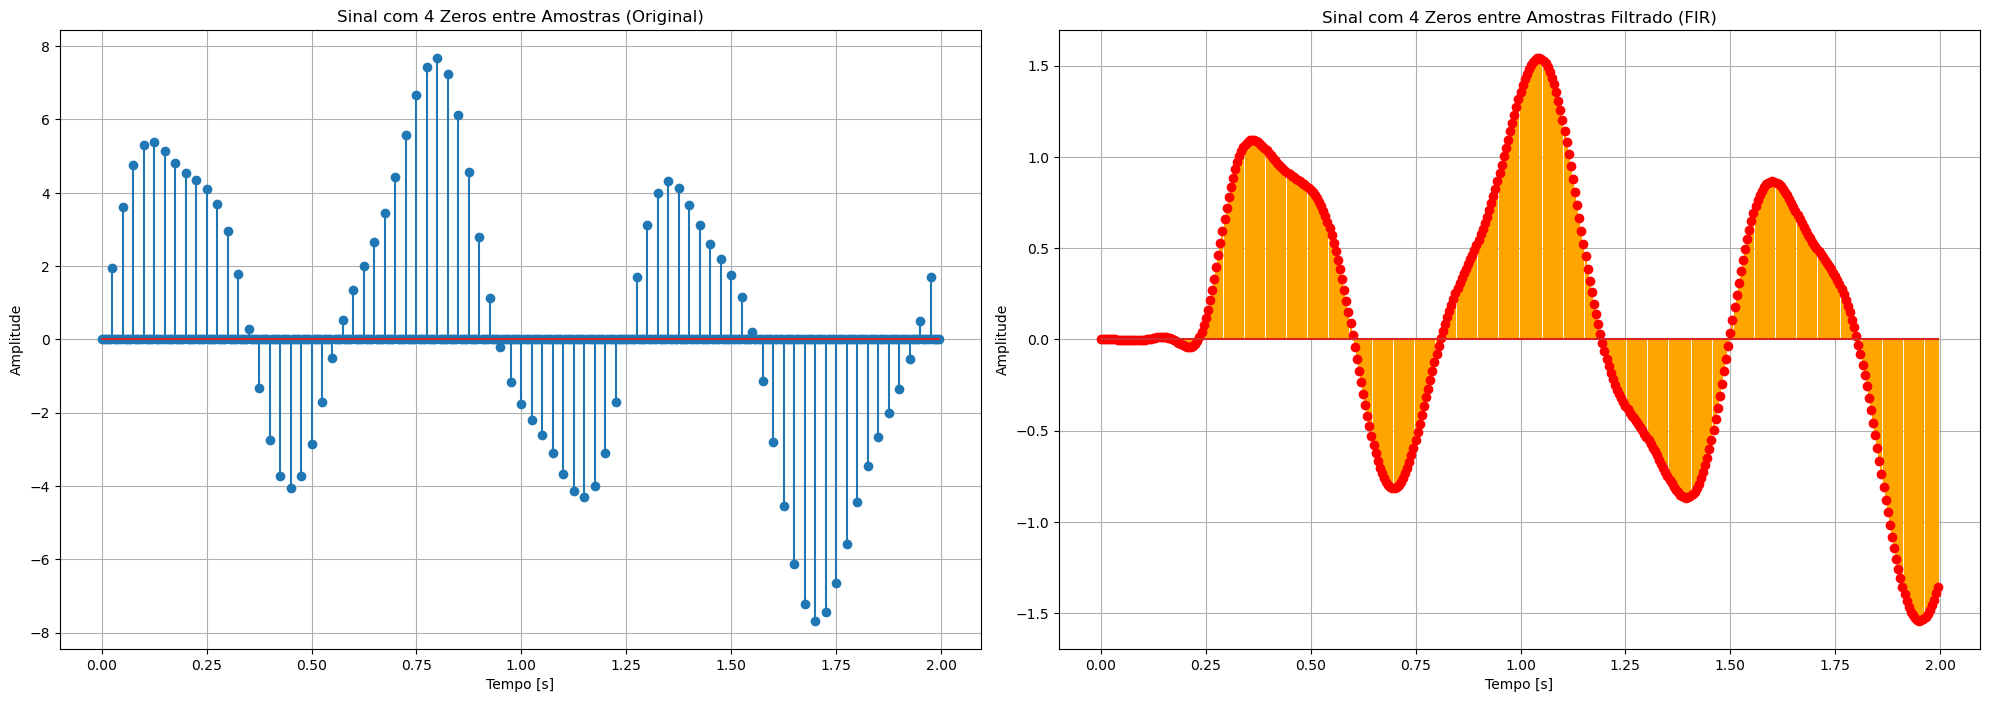

In [63]:
plt.figure(figsize=(20, 20))

plt.subplot(3, 2, 5)
plt.stem(n_upsampled, sinal_upsampled, label='Original')
plt.title(f'Sinal com {L} Zeros entre Amostras (Original)')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(3, 2, 6)
plt.stem(n_upsampled, sinal_filtrado_upsampled, label='Filtrado', linefmt='orange', markerfmt='ro')
plt.title(f'Sinal com {L} Zeros entre Amostras Filtrado (FIR)')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()


<h4>
    O processo de filtragem do sinal interpolado acima não é otimizado, pois suas amostragem de amplitude zero entram no processo de multiplicação na filtragem, mas elas não trazem contribuição alguma para a informação do sinal
</h4>
<h4>
    Em um processomelhorado de interpolação de sinal com filtros polifásicos, essas multiplicações por zero são eliminadas, diminuindo assim o uso de CPU. Um filtro polifásico é formado por uma sequência de filtros FIR a depender de do fator de interpolação do sinal.
</h4>

<h4>
    Considade que o bloco abaixo descreve um filtro FIR de K taps tenho um sinal x[n] qualquer como entrada:
</h4>
<br/>
<br/>
<img src="FIR.png" style="display: block; margin: 0 auto; width: 340px;" />
<br/>
<br/>
<h4>
    Caso eu queria fazer uma interpolação por um fator L = 4 e 12 taps, por exemplo, basta fazer um banco com 4 filtros FIR e distribuir as taps entre eles, tendo então:
</h4>
<br/>
<br/>
<img src="polyphase_diagram.png" style="display: block; margin: 0 auto; width: 340px;" />
<br/>
<br/>
<h4>
    Uma outra forma é ter apenas um filtro FIR e comutar a entrada dos coeficientes, de forma que:
</h4>
<br/>
<br/>
<img src="commutated.png" style="display: block; margin: 0 auto; width: 400px;" />
<br/>
<br/>


## Implementando o filtro polifásico para interpolação:

In [65]:
def polyphase_filter(unsampled_signal, n_taps, cutoff, M):

    if n_taps % M != 0:
        n_taps += (M - n_taps % M)  

    h = signal.firwin(n_taps, cutoff)

    h_poly = np.zeros((M, n_taps // M))
    for i in range(M):
        h_poly[i] = h[i::M]

    upsampled_length = len(unsampled_signal) * M
    upsampled_signal = np.zeros(upsampled_length)
    upsampled_signal[::M] = unsampled_signal

    output_signal = np.zeros(upsampled_length)

    for i in range(M):
        phase_signal = signal.lfilter(h_poly[i], 1, upsampled_signal)
        output_signal += np.roll(phase_signal, i) 

    return output_signal


## Plotando o Sinal de saída do filtro polifásico

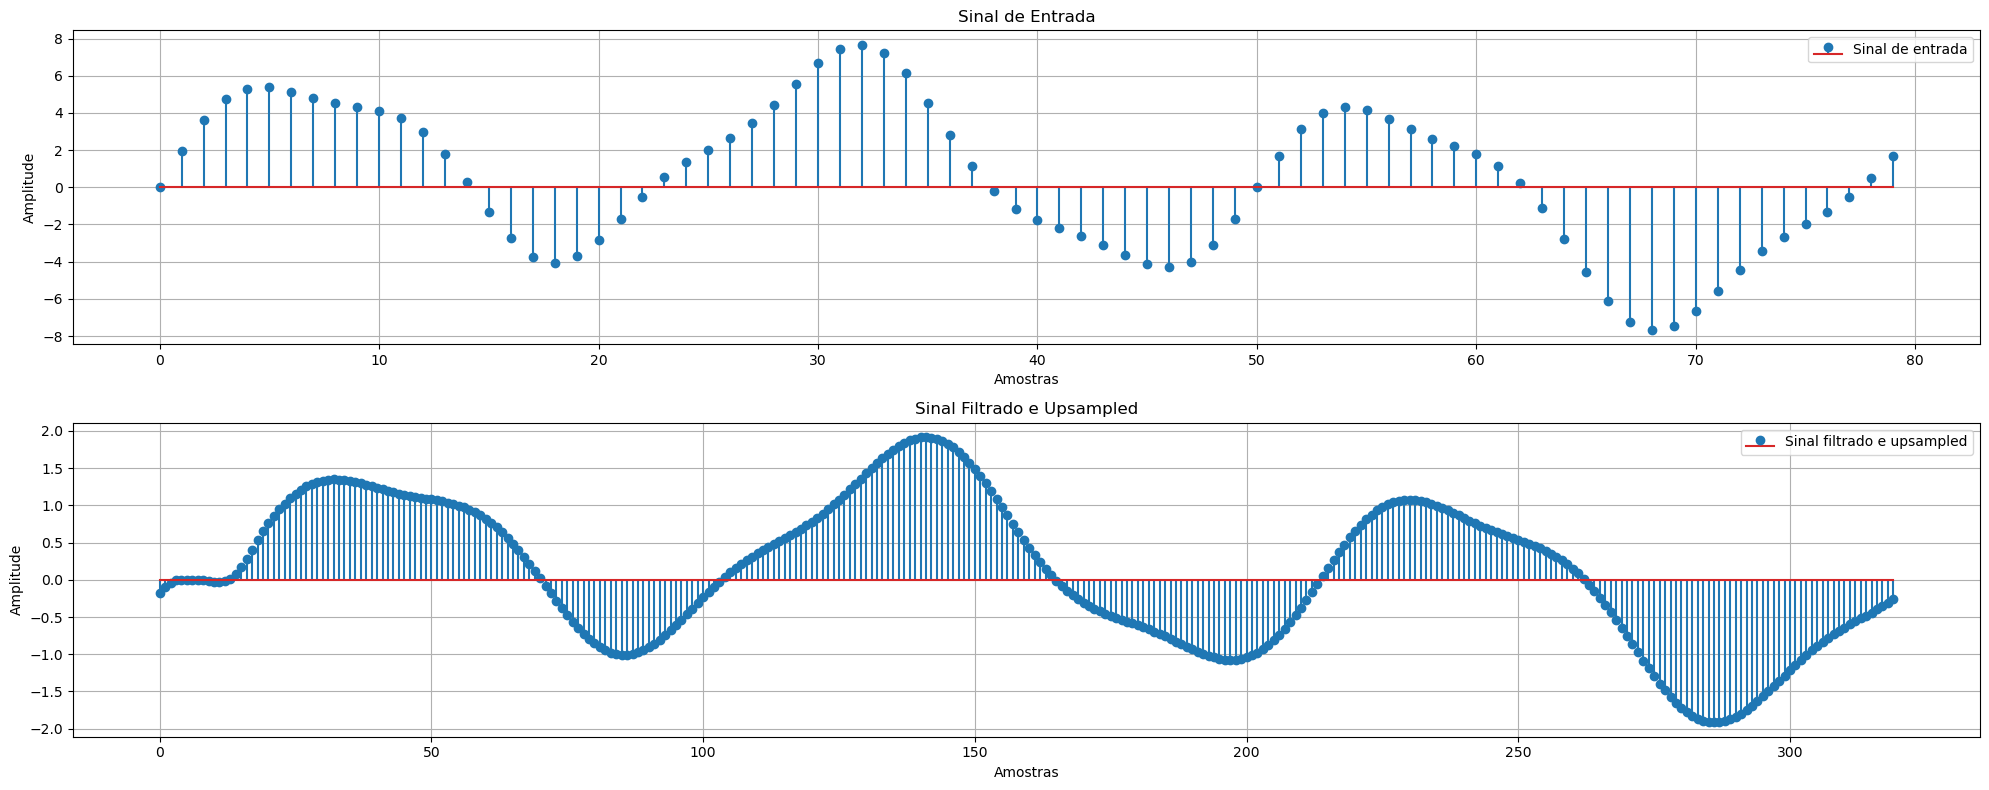

In [71]:
polyphasefilter_signal = polyphase_filter(sinal_n, 100, (frequencia/(L*20)), L)

plt.figure(figsize=(20, 8))

# Gráfico do sinal de entrada
plt.subplot(2, 1, 1)
plt.stem(sinal_n, label='Sinal de entrada')
plt.title('Sinal de Entrada')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.grid()

plt.legend()

# Gráfico do sinal filtrado
plt.subplot(2, 1, 2)
plt.stem(polyphasefilter_signal, label='Sinal filtrado e upsampled')
plt.title('Sinal Filtrado e Upsampled')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()
